In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
import optuna
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

2025-12-15 15:45:16.048896: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-15 15:45:16.115892: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-15 15:45:17.873578: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-15 15:45:17.873578: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


TensorFlow version: 2.20.0
GPU available: []


2025-12-15 15:45:20.925587: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## 1. Load Preprocessed Data

In [2]:
# Load preprocessed data
df = pd.read_csv('../data/processed/preprocessed_daily_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"Data shape: {df.shape}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Data shape: (182, 7)
Date range: 2022-06-06 00:00:00 to 2022-12-04 00:00:00

Columns: ['temperature_surface', 'temperature_atmosphere', 'relative_humidity', 'cond_low_freq', 'cond_high_freq', 'corrosion_rate', 'timestamp']


,temperature_surface,temperature_atmosphere,relative_humidity,cond_low_freq,cond_high_freq,corrosion_rate,timestamp
0,0.632285,0.610431,0.446010,0.000000,0.000461,0.000000,2022-06-06
1,0.534886,0.510246,0.654171,0.379351,0.534253,0.177523,2022-06-07
2,0.572193,0.547030,0.628759,0.389296,0.589568,0.061214,2022-06-08
3,0.698320,0.681420,0.574287,0.479568,1.000000,0.087289,2022-06-09
4,0.695093,0.676903,0.571560,0.358947,0.001437,0.000000,2022-06-10


In [3]:
# Load scaler for inverse transformation later
scaler = joblib.load('../models/minmax_scaler.pkl')
print("Scaler loaded successfully")

Scaler loaded successfully


## 2. Prepare Sequences for Time Series Prediction

Create sequences where we use past N days to predict the next day's corrosion rate.

In [4]:
# Define feature columns and target column
feature_cols = ['temperature_surface', 'temperature_atmosphere', 'relative_humidity', 
                'cond_low_freq', 'cond_high_freq']
target_col = 'corrosion_rate'

# NO SEQUENCE: Direct prediction (current day features -> current day corrosion)
# This maximizes training samples and matches the paper's likely approach
USE_SEQUENCES = False
SEQUENCE_LENGTH = 1  # Only used if USE_SEQUENCES = True

print(f"Input features: {feature_cols}")
print(f"Target: {target_col}")
print(f"Using sequences: {USE_SEQUENCES}")
if USE_SEQUENCES:
    print(f"Sequence length: {SEQUENCE_LENGTH} days")
else:
    print("Direct prediction: current day features -> current day corrosion rate")

Input features: ['temperature_surface', 'temperature_atmosphere', 'relative_humidity', 'cond_low_freq', 'cond_high_freq']
Target: corrosion_rate
Using sequences: False
Direct prediction: current day features -> current day corrosion rate


In [5]:
def create_sequences(data, feature_cols, target_col, seq_length):
    """
    Create sequences for time series prediction.
    
    Args:
        data: DataFrame with normalized data
        feature_cols: List of feature column names
        target_col: Name of target column
        seq_length: Number of time steps in each sequence
    
    Returns:
        X: Input sequences (samples, seq_length, features)
        y: Target values (samples,)
        timestamps: Corresponding timestamps for each prediction
    """
    X, y, timestamps = [], [], []
    
    for i in range(len(data) - seq_length):
        # Input sequence: past seq_length days
        X.append(data[feature_cols].iloc[i:i+seq_length].values)
        # Target: next day's corrosion rate
        y.append(data[target_col].iloc[i+seq_length])
        # Timestamp of prediction
        timestamps.append(data['timestamp'].iloc[i+seq_length])
    
    return np.array(X), np.array(y), timestamps

# Prepare data based on USE_SEQUENCES flag
if USE_SEQUENCES:
    # Create sequences (multi-day temporal patterns)
    X, y, timestamps = create_sequences(df, feature_cols, target_col, SEQUENCE_LENGTH)
    print(f"\nSequence creation complete:")
    print(f"X shape: {X.shape} (samples, sequence_length, features)")
    print(f"y shape: {y.shape} (samples,)")
    print(f"Number of sequences: {len(X)}")
else:
    # Direct prediction: no sequences, use all data
    X = df[feature_cols].values
    y = df[target_col].values
    timestamps = df['timestamp'].tolist()
    
    # Reshape for Conv1D compatibility: (samples, timesteps=1, features)
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    print(f"\nDirect prediction mode:")
    print(f"X shape: {X.shape} (samples, timesteps=1, features)")
    print(f"y shape: {y.shape} (samples,)")
    print(f"Total samples: {len(X)}")


Direct prediction mode:
X shape: (182, 1, 5) (samples, timesteps=1, features)
y shape: (182,) (samples,)
Total samples: 182


## 3. Train/Test Split

In [6]:
# Split data: 64% train, 36% test (matching paper's 4 months train / 2 months test)
# Use temporal split (not random) to maintain time series integrity
# Paper uses June-Sept (4 months) for training, Oct-Dec (2 months) for testing
split_idx = int(len(X) * 0.64)

X_train = X[:split_idx]
X_test = X[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]
timestamps_train = timestamps[:split_idx]
timestamps_test = timestamps[split_idx:]

print(f"Training set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  Date range: {timestamps_train[0]} to {timestamps_train[-1]}")

print(f"\nTest set:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")
print(f"  Date range: {timestamps_test[0]} to {timestamps_test[-1]}")

Training set:
  X_train shape: (116, 1, 5)
  y_train shape: (116,)
  Date range: 2022-06-06 00:00:00 to 2022-09-29 00:00:00

Test set:
  X_test shape: (66, 1, 5)
  y_test shape: (66,)
  Date range: 2022-09-30 00:00:00 to 2022-12-04 00:00:00


## 4. Build CGRU Model Architecture

In [7]:
def build_cgru_model(seq_length, n_features, conv_filters=64, gru_units=50, learning_rate=0.001, dropout_rate=0.2):
    """
    Build Convolutional Gated Recurrent Unit (CGRU) model.
    
    Architecture:
    1. Conv1D layer with SELU activation (feature extraction)
    2. GRU layer with SELU activation (temporal pattern learning)
    3. Dense layer with Sigmoid activation (output prediction)
    
    Args:
        seq_length: Length of input sequences (1 for direct prediction)
        n_features: Number of features
        conv_filters: Number of convolutional filters
        gru_units: Number of GRU units
        learning_rate: Learning rate for Adam optimizer
        dropout_rate: Dropout rate for regularization
    
    Returns:
        Compiled Keras model
    """
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(seq_length, n_features)),
        
        # Convolutional layer for feature extraction
        layers.Conv1D(filters=conv_filters, kernel_size=3, padding='same', 
                      activation='selu', name='conv1d'),
        
        # GRU layer for temporal pattern learning
        layers.GRU(units=gru_units, activation='selu', name='gru'),
        
        # Dropout for regularization
        layers.Dropout(dropout_rate, name='dropout'),
        
        # Output layer with sigmoid activation (for normalized [0,1] output)
        layers.Dense(1, activation='sigmoid', name='output')
    ])
    
    # Compile with Adam optimizer and MSE loss
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae', 'mse']
    )
    
    return model

# Build initial model with default hyperparameters
seq_len = 1 if not USE_SEQUENCES else SEQUENCE_LENGTH
model = build_cgru_model(
    seq_length=seq_len,
    n_features=len(feature_cols),
    conv_filters=64,
    gru_units=50,
    learning_rate=0.001,
    dropout_rate=0.2
)

print("\nModel Architecture:")
model.summary()


Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 64)          │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 50)             │        17,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,475 (72.17 KB)

 Trainable params: 18,475 (72.17 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Train Model with Default Hyperparameters

In [8]:
# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

# Train model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # 20% of training data for validation
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.1097 - mae: 0.3018 - mse: 0.1097 - val_loss: 0.0918 - val_mae: 0.2908 - val_mse: 0.0918 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.1097 - mae: 0.3018 - mse: 0.1097 - val_loss: 0.0918 - val_mae: 0.2908 - val_mse: 0.0918 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0586 - mae: 0.2242 - mse: 0.0586 - val_loss: 0.0463 - val_mae: 0.2023 - val_mse: 0.0463 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0586 - mae: 0.2242 - mse: 0.0586 - val_loss: 0.0463 - val_mae: 0.2023 - val_mse: 0.0463 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0395 - mae: 0.1814 - mse: 0.0395 - val_loss: 0.0241 - val_mae: 0.1412 - val_mse: 0.0241 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0395 - mae: 0.1814 - mse: 0.0395 - val_loss: 0.0241 - val_mae: 0.1412 - val_mse:

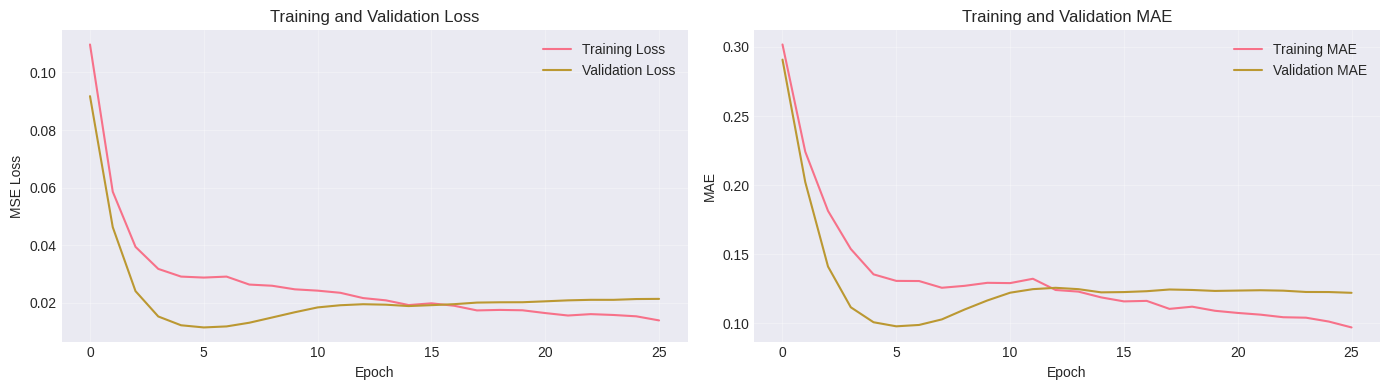

In [9]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Training MAE')
axes[1].plot(history.history['val_mae'], label='Validation MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Training and Validation MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Evaluate Model on Test Set

In [10]:
# Make predictions on test set
y_pred = model.predict(X_test).flatten()

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test Set Performance:")
print(f"  MSE:  {mse:.6f}")
print(f"  RMSE: {rmse:.6f}")
print(f"  MAE:  {mae:.6f}")
print(f"  R²:   {r2:.6f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Test Set Performance:
  MSE:  0.044584
  RMSE: 0.211149
  MAE:  0.181493
  R²:   -1.151332
Test Set Performance:
  MSE:  0.044584
  RMSE: 0.211149
  MAE:  0.181493
  R²:   -1.151332


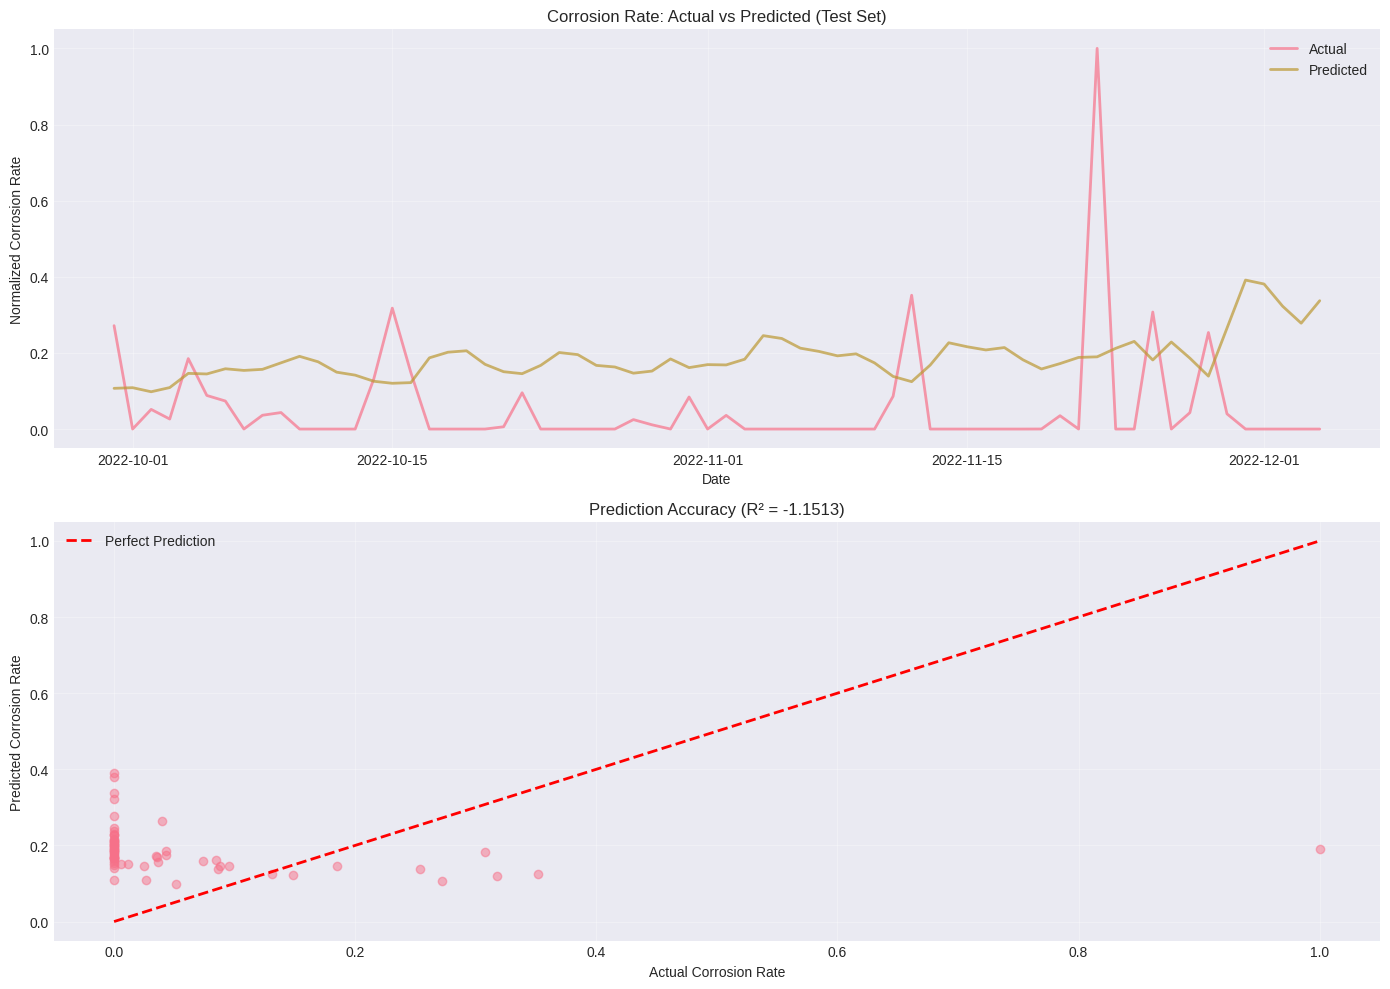

In [11]:
# Plot predictions vs actual values
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Time series plot
axes[0].plot(timestamps_test, y_test, label='Actual', linewidth=2, alpha=0.7)
axes[0].plot(timestamps_test, y_pred, label='Predicted', linewidth=2, alpha=0.7)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Normalized Corrosion Rate')
axes[0].set_title('Corrosion Rate: Actual vs Predicted (Test Set)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter plot
axes[1].scatter(y_test, y_pred, alpha=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Corrosion Rate')
axes[1].set_ylabel('Predicted Corrosion Rate')
axes[1].set_title(f'Prediction Accuracy (R² = {r2:.4f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Hyperparameter Optimization with Optuna

In [12]:
def objective(trial):
    """
    Optuna objective function for hyperparameter optimization.
    """
    # Hyperparameters to optimize
    conv_filters = trial.suggest_int('conv_filters', 32, 128, step=16)
    gru_units = trial.suggest_int('gru_units', 32, 128, step=16)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])  # Larger batches for more data
    dropout_rate = trial.suggest_float('dropout_rate', 0.05, 0.3)  # Lower dropout range
    
    # Build model with suggested hyperparameters
    seq_len = 1 if not USE_SEQUENCES else SEQUENCE_LENGTH
    model = models.Sequential([
        layers.Input(shape=(seq_len, len(feature_cols))),
        layers.Conv1D(filters=conv_filters, kernel_size=3, padding='same', activation='selu'),
        layers.GRU(units=gru_units, activation='selu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    
    # Early stopping callback
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,  # Reduced for optimization speed
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )
    
    # Return validation loss
    return min(history.history['val_loss'])

print("Starting hyperparameter optimization...")
print("This may take a while...\n")

Starting hyperparameter optimization...
This may take a while...



In [13]:
# Run Optuna optimization
study = optuna.create_study(direction='minimize', study_name='cgru_optimization')
study.optimize(objective, n_trials=20, show_progress_bar=True)

print("\nOptimization complete!")
print(f"\nBest trial: {study.best_trial.number}")
print(f"Best validation loss: {study.best_trial.value:.6f}")
print(f"\nBest hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

[I 2025-12-15 15:45:27,904] A new study created in memory with name: cgru_optimization


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-15 15:45:31,718] Trial 0 finished with value: 0.009086617268621922 and parameters: {'conv_filters': 32, 'gru_units': 96, 'learning_rate': 0.0018196409240355323, 'batch_size': 16, 'dropout_rate': 0.10429761586769616}. Best is trial 0 with value: 0.009086617268621922.
[I 2025-12-15 15:45:36,545] Trial 1 finished with value: 0.01708761788904667 and parameters: {'conv_filters': 128, 'gru_units': 64, 'learning_rate': 0.00028799188129955474, 'batch_size': 32, 'dropout_rate': 0.05276125230621205}. Best is trial 0 with value: 0.009086617268621922.
[I 2025-12-15 15:45:36,545] Trial 1 finished with value: 0.01708761788904667 and parameters: {'conv_filters': 128, 'gru_units': 64, 'learning_rate': 0.00028799188129955474, 'batch_size': 32, 'dropout_rate': 0.05276125230621205}. Best is trial 0 with value: 0.009086617268621922.
[I 2025-12-15 15:45:40,589] Trial 2 finished with value: 0.007293171714991331 and parameters: {'conv_filters': 128, 'gru_units': 32, 'learning_rate': 0.002303452685

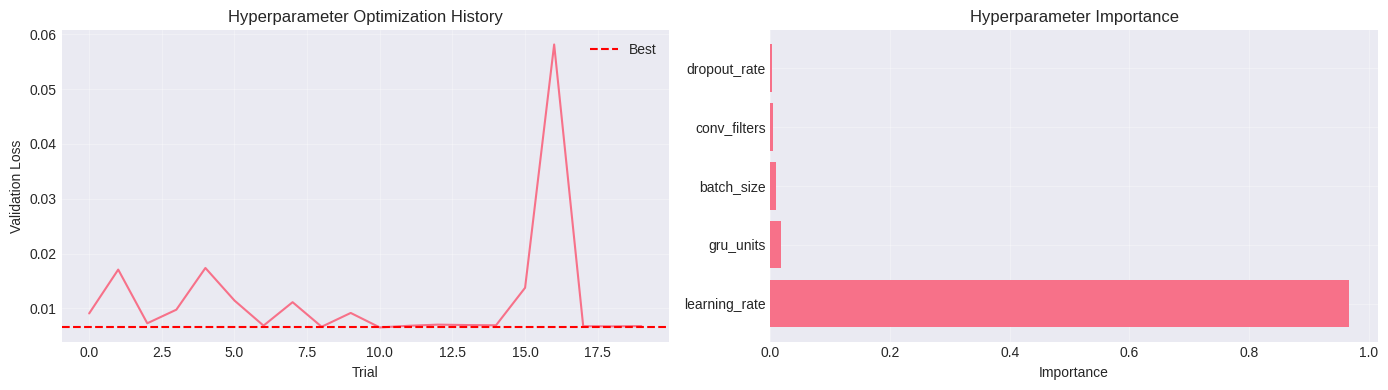

In [14]:
# Visualize optimization history
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Optimization history
axes[0].plot([trial.value for trial in study.trials])
axes[0].axhline(y=study.best_trial.value, color='r', linestyle='--', label='Best')
axes[0].set_xlabel('Trial')
axes[0].set_ylabel('Validation Loss')
axes[0].set_title('Hyperparameter Optimization History')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Parameter importance
importance = optuna.importance.get_param_importances(study)
params = list(importance.keys())
values = list(importance.values())
axes[1].barh(params, values)
axes[1].set_xlabel('Importance')
axes[1].set_title('Hyperparameter Importance')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Train Final Model with Best Hyperparameters

In [15]:
# Build final model with best hyperparameters
best_params = study.best_trial.params

seq_len = 1 if not USE_SEQUENCES else SEQUENCE_LENGTH
final_model = models.Sequential([
    layers.Input(shape=(seq_len, len(feature_cols))),
    layers.Conv1D(filters=best_params['conv_filters'], kernel_size=3, 
                  padding='same', activation='selu', name='conv1d'),
    layers.GRU(units=best_params['gru_units'], activation='selu', name='gru'),
    layers.Dropout(best_params['dropout_rate'], name='dropout'),
    layers.Dense(1, activation='sigmoid', name='output')
])

final_model.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    loss='mse',
    metrics=['mae', 'mse']
)

print("Final Model Architecture:")
final_model.summary()

Final Model Architecture:


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 64)          │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,649 (295.50 KB)

 Trainable params: 75,649 (295.50 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train final model with more epochs
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,
    min_lr=1e-7,
    verbose=1
)

final_history = final_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - loss: 0.1317 - mae: 0.3230 - mse: 0.1317 - val_loss: 0.0102 - val_mae: 0.0928 - val_mse: 0.0102 - learning_rate: 0.0097
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - loss: 0.1317 - mae: 0.3230 - mse: 0.1317 - val_loss: 0.0102 - val_mae: 0.0928 - val_mse: 0.0102 - learning_rate: 0.0097
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0333 - mae: 0.1325 - mse: 0.0333 - val_loss: 0.0068 - val_mae: 0.0680 - val_mse: 0.0068 - learning_rate: 0.0097
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0333 - mae: 0.1325 - mse: 0.0333 - val_loss: 0.0068 - val_mae: 0.0680 - val_mse: 0.0068 - learning_rate: 0.0097
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0336 - mae: 0.1150 - mse: 0.0336 - val_loss: 0.0071 - val_mae: 0.0749 - val_mse: 0.0071 - learning_rate: 0.0097
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0336 - mae: 0.1150 - mse: 0.0336 - val_loss: 0.0071 - val_mae: 0.0749 - val_ms

In [17]:
# Evaluate final model on test set
y_pred_final = final_model.predict(X_test).flatten()

# Calculate metrics
mse_final = mean_squared_error(y_test, y_pred_final)
rmse_final = np.sqrt(mse_final)
mae_final = mean_absolute_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print("\n" + "="*60)
print("FINAL MODEL PERFORMANCE ON TEST SET")
print("="*60)
print(f"MSE:  {mse_final:.6f}")
print(f"RMSE: {rmse_final:.6f}")
print(f"MAE:  {mae_final:.6f}")
print(f"R²:   {r2_final:.6f}")
print("="*60)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

FINAL MODEL PERFORMANCE ON TEST SET
MSE:  0.029774
RMSE: 0.172553
MAE:  0.122666
R²:   -0.436716
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

FINAL MODEL PERFORMANCE ON TEST SET
MSE:  0.029774
RMSE: 0.172553
MAE:  0.122666
R²:   -0.436716


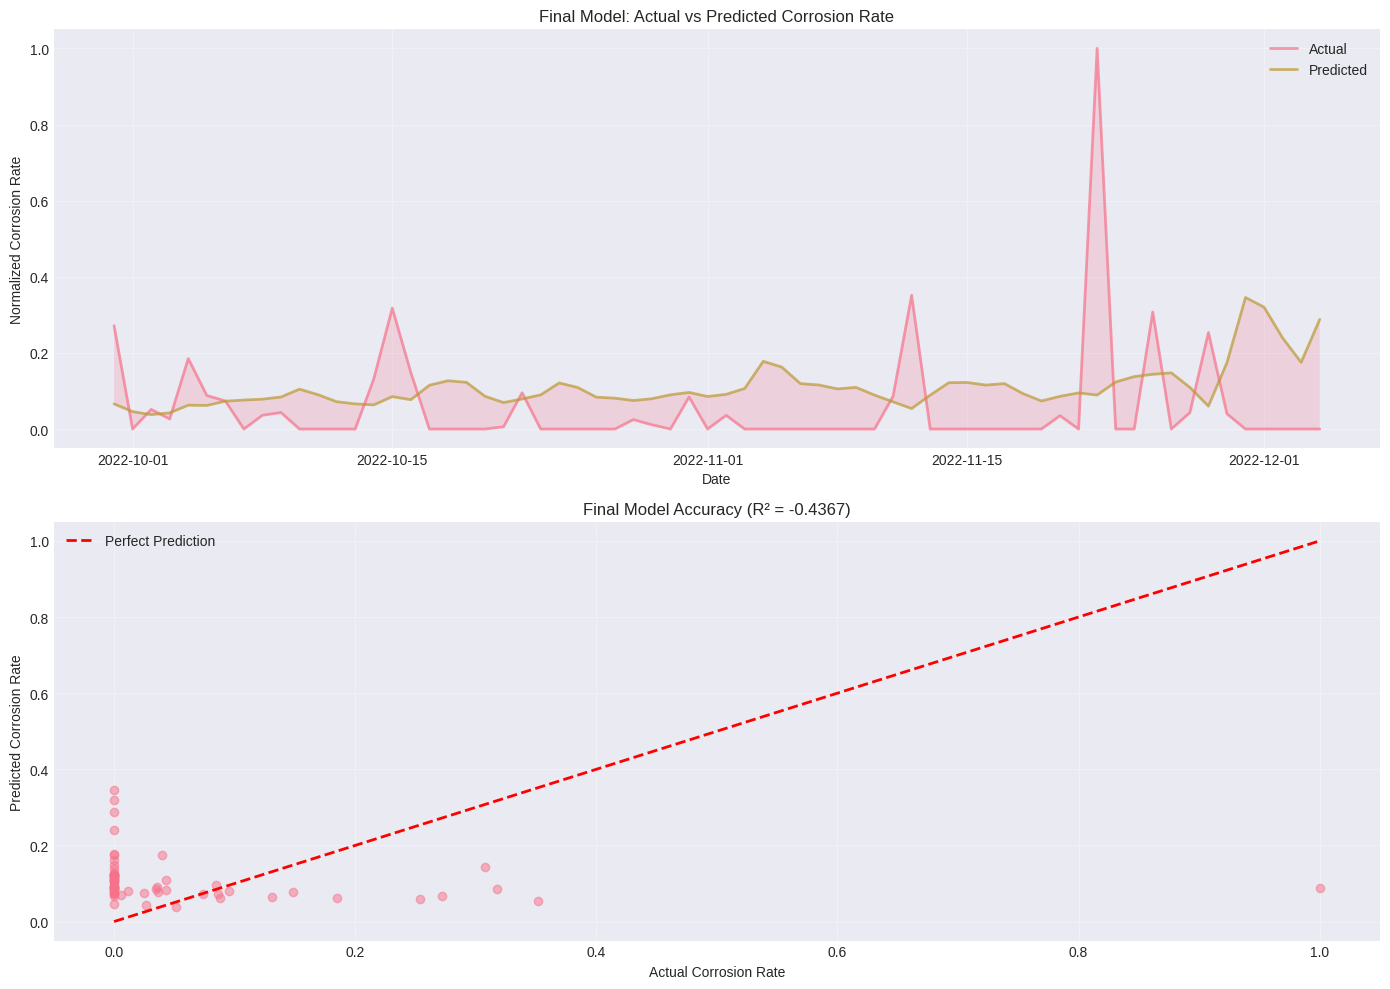

In [18]:
# Plot final model predictions
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Time series plot
axes[0].plot(timestamps_test, y_test, label='Actual', linewidth=2, alpha=0.7)
axes[0].plot(timestamps_test, y_pred_final, label='Predicted', linewidth=2, alpha=0.7)
axes[0].fill_between(timestamps_test, y_test, y_pred_final, alpha=0.2)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Normalized Corrosion Rate')
axes[0].set_title('Final Model: Actual vs Predicted Corrosion Rate')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter plot
axes[1].scatter(y_test, y_pred_final, alpha=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Corrosion Rate')
axes[1].set_ylabel('Predicted Corrosion Rate')
axes[1].set_title(f'Final Model Accuracy (R² = {r2_final:.4f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Save Final Model and Artifacts

In [19]:
# Save model
model_path = '../models/cgru_corrosion_model.h5'
final_model.save(model_path)
print(f"Model saved to: {model_path}")

# Save training history
history_path = '../models/training_history.json'
history_dict = {
    'loss': [float(x) for x in final_history.history['loss']],
    'val_loss': [float(x) for x in final_history.history['val_loss']],
    'mae': [float(x) for x in final_history.history['mae']],
    'val_mae': [float(x) for x in final_history.history['val_mae']]
}
with open(history_path, 'w') as f:
    json.dump(history_dict, f, indent=2)
print(f"Training history saved to: {history_path}")

# Save best hyperparameters
params_path = '../models/best_hyperparameters.json'
with open(params_path, 'w') as f:
    json.dump(best_params, f, indent=2)
print(f"Best hyperparameters saved to: {params_path}")

# Save model metadata
seq_len = 1 if not USE_SEQUENCES else SEQUENCE_LENGTH
metadata = {
    'model_type': 'CGRU (Convolutional GRU)',
    'use_sequences': USE_SEQUENCES,
    'sequence_length': seq_len,
    'features': feature_cols,
    'target': target_col,
    'test_metrics': {
        'mse': float(mse_final),
        'rmse': float(rmse_final),
        'mae': float(mae_final),
        'r2': float(r2_final)
    },
    'hyperparameters': best_params,
    'training_samples': int(len(X_train)),
    'test_samples': int(len(X_test))
}

metadata_path = '../models/model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Model metadata saved to: {metadata_path}")

print("\nAll artifacts saved successfully!")

Model saved to: ../models/cgru_corrosion_model.h5
Training history saved to: ../models/training_history.json
Best hyperparameters saved to: ../models/best_hyperparameters.json
Model metadata saved to: ../models/model_metadata.json

All artifacts saved successfully!


## 10. Model Summary

In [20]:
seq_len = 1 if not USE_SEQUENCES else SEQUENCE_LENGTH
print("="*70)
print("MODEL TRAINING SUMMARY")
print("="*70)
print(f"\nModel Type: Convolutional Gated Recurrent Unit (CGRU)")
print(f"\nArchitecture:")
print(f"  - Conv1D layer with {best_params['conv_filters']} filters (SELU)")
print(f"  - GRU layer with {best_params['gru_units']} units (SELU)")
print(f"  - Dropout layer ({best_params['dropout_rate']:.2f})")
print(f"  - Dense output layer (Sigmoid)")
print(f"\nTraining Configuration:")
print(f"  - Optimizer: Adam (lr={best_params['learning_rate']:.6f})")
print(f"  - Loss: Mean Squared Error (MSE)")
print(f"  - Batch size: {best_params['batch_size']}")
print(f"  - Epochs: {len(final_history.history['loss'])}")
print(f"\nData:")
print(f"  - Use sequences: {USE_SEQUENCES}")
print(f"  - Sequence length: {seq_len} day(s)")
print(f"  - Training samples: {len(X_train)}")
print(f"  - Test samples: {len(X_test)}")
print(f"\nTest Performance:")
print(f"  - MSE:  {mse_final:.6f}")
print(f"  - RMSE: {rmse_final:.6f}")
print(f"  - MAE:  {mae_final:.6f}")
print(f"  - R²:   {r2_final:.6f}")
print(f"\nSaved Artifacts:")
print(f"  - Model: {model_path}")
print(f"  - Scaler: ../models/minmax_scaler.pkl")
print(f"  - Metadata: {metadata_path}")
print("\n" + "="*70)
print("Model ready for deployment in digital twin!")
print("="*70)

MODEL TRAINING SUMMARY

Model Type: Convolutional Gated Recurrent Unit (CGRU)

Architecture:
  - Conv1D layer with 64 filters (SELU)
  - GRU layer with 128 units (SELU)
  - Dropout layer (0.18)
  - Dense output layer (Sigmoid)

Training Configuration:
  - Optimizer: Adam (lr=0.009745)
  - Loss: Mean Squared Error (MSE)
  - Batch size: 64
  - Epochs: 32

Data:
  - Use sequences: False
  - Sequence length: 1 day(s)
  - Training samples: 116
  - Test samples: 66

Test Performance:
  - MSE:  0.029774
  - RMSE: 0.172553
  - MAE:  0.122666
  - R²:   -0.436716

Saved Artifacts:
  - Model: ../models/cgru_corrosion_model.h5
  - Scaler: ../models/minmax_scaler.pkl
  - Metadata: ../models/model_metadata.json

Model ready for deployment in digital twin!
